# 🧠 Classificação e Segmentação de Imagens de Ultrassom da Mama
Usando VGG-16 (classificação) e U-Net (segmentação) com o dataset do Kaggle.

In [1]:
%pip install tensorflow opencv-python scikit-learn matplotlib kaggle

Note: you may need to restart the kernel to use updated packages.


## 📥 Download do Dataset via Kaggle API

In [2]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
breast-ultrasound-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import os, zipfile

os.environ['KAGGLE_CONFIG_DIR'] = '.'

with zipfile.ZipFile("breast-ultrasound-images-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("breast_ultrasound_dataset")

print("✅ Dataset baixado e extraído com sucesso!")


✅ Dataset baixado e extraído com sucesso!


## 📁 Importação de Bibliotecas

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import tensorflow as tf

In [5]:
%pip install scikit-image scipy

from preprocessing_pipeline import UltrasoundPreprocessor, preprocess_batch, demonstrate_preprocessing
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology, measure
from scipy import ndimage
from skimage.feature import canny

# Instância global do pré-processador
preprocessor = UltrasoundPreprocessor(target_size=(224, 224))

print("✅ Pipeline de pré-processamento carregado com sucesso!")

Note: you may need to restart the kernel to use updated packages.
✅ Pipeline de pré-processamento carregado com sucesso!


## Demonstração do pipeline

🔧 Demonstração do Pipeline de Pré-processamento


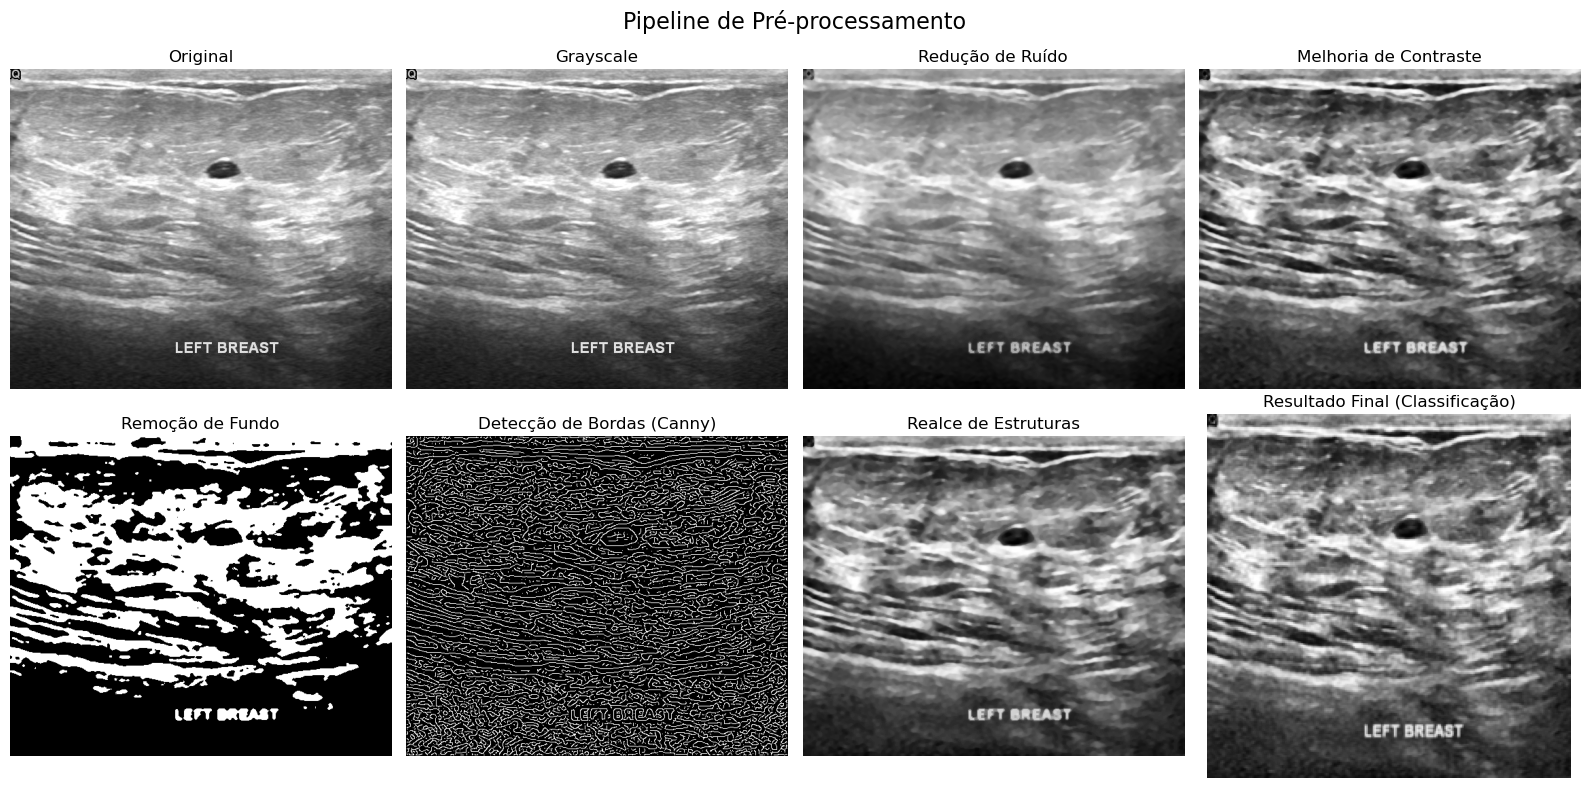


📊 Resultados do Pré-processamento:


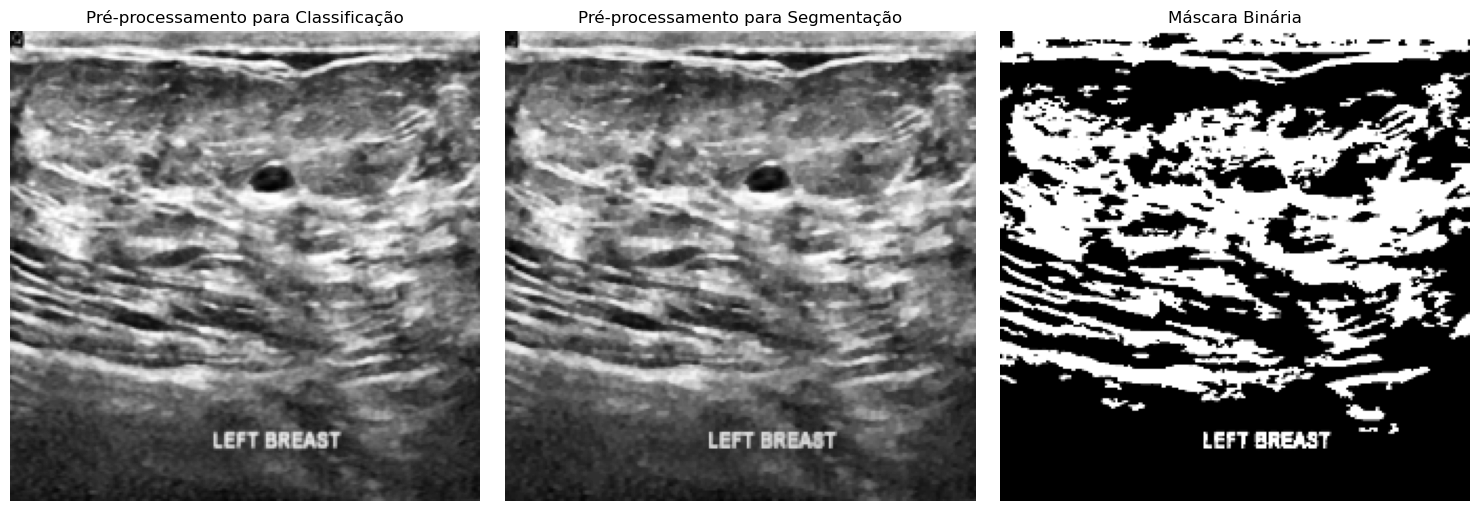

✅ Demonstração concluída!


In [6]:
sample_image_path = 'breast_ultrasound_dataset/Dataset_BUSI_with_GT/benign/benign (1).png'
demonstrate_preprocessing(sample_image_path)

## 🗂️ Carregamento e Pré-processamento para Classificação

In [7]:
base_path = 'breast_ultrasound_dataset/Dataset_BUSI_with_GT/'
classes = ['benign', 'malignant', 'normal']
img_size = 224

X = []
y = []

print("🔄 Carregando e pré-processando imagens para classificação...")

for idx, label in enumerate(classes):
    folder = os.path.join(base_path, label)
    print(f"   Processando classe: {label}")
    
    for filename in os.listdir(folder):
        if 'mask' not in filename:
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            
            # Aplica pré-processamento otimizado para classificação
            processed_img = preprocessor.preprocess_for_classification(
                img,
                apply_grayscale=True,
                apply_noise_reduction=True,
                apply_contrast=True,
                apply_background_removal=False,  # Opcional para classificação
                apply_edge_detection=False       # Opcional para classificação
            )
            
            # Converte para 3 canais se necessário para VGG-16
            if len(processed_img.shape) == 2:
                processed_img = np.stack([processed_img] * 3, axis=-1)
            
            X.append(processed_img)
            y.append(idx)

X = np.array(X)
y = to_categorical(y, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f"✅ Dataset carregado: {len(X)} imagens, {len(classes)} classes")
print(f"   Treino: {len(X_train)} imagens")
print(f"   Teste: {len(X_test)} imagens")

🔄 Carregando e pré-processando imagens para classificação...
   Processando classe: benign
   Processando classe: malignant
   Processando classe: normal
✅ Dataset carregado: 780 imagens, 3 classes
   Treino: 624 imagens
   Teste: 156 imagens


## 🧠 Modelo VGG-16 para Classificação

In [8]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in vgg.layers:
    layer.trainable = False

x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model_class = Model(inputs=vgg.input, outputs=predictions)
model_class.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_class.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 📊 Treinamento do Modelo de Classificação

In [9]:
model_class.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=16)

Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 0.4915 - loss: 1.0707 - val_accuracy: 0.5577 - val_loss: 0.9202
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.6033 - loss: 0.8805 - val_accuracy: 0.6154 - val_loss: 0.8657
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 173s 4s/step - accuracy: 0.6192 - loss: 0.8603 - val_accuracy: 0.6218 - val_loss: 0.8047
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 205s 5s/step - accuracy: 0.6898 - loss: 0.7554 - val_accuracy: 0.6795 - val_loss: 0.7714
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 208s 5s/step - accuracy: 0.6627 - loss: 0.7887 - val_accuracy: 0.6859 - val_loss: 0.7794


In [10]:
loss, accuracy = model_class.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step - accuracy: 0.6878 - loss: 0.7951
Test Loss: 0.7794
Test Accuracy: 0.6859


## 🖼️ Função para Carregar Imagens e Máscaras (Segmentação)

In [12]:
def load_images_and_masks_with_preprocessing(class_folder):
    img_list = []
    mask_list = []
    folder = os.path.join(base_path, class_folder)
    
    print(f"🔄 Carregando imagens e máscaras para {class_folder} com pré-processamento...")
    
    for fname in os.listdir(folder):
        if 'mask' not in fname:
            img_path = os.path.join(folder, fname)
            mask_path = os.path.join(folder, fname.split('.')[0] + '_mask.png')
            
            if not os.path.exists(mask_path): 
                continue
                
            # Carrega imagem original
            img = cv2.imread(img_path)
            
            # Aplica pré-processamento otimizado para segmentação
            processed_img = preprocessor.preprocess_for_segmentation(
                img,
                apply_grayscale=True,
                apply_noise_reduction=True,
                apply_contrast=True,
                apply_structure_enhancement=True
            )
            
            # Carrega e processa máscara
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (128, 128))
            mask = np.expand_dims(mask, axis=-1) / 255.0
            
            img_list.append(processed_img)
            mask_list.append(mask)
    
    print(f"   ✅ {len(img_list)} imagens processadas para {class_folder}")
    return img_list, mask_list

## 📥 Carregamento dos Dados de Segmentação

In [13]:
X_seg, y_seg = [], []
for c in ['benign', 'malignant']:
    imgs, masks = load_images_and_masks_with_preprocessing(c)
    X_seg += imgs
    y_seg += masks

X_seg = np.array(X_seg)
y_seg = np.array(y_seg)

X_train_seg, X_val_seg, y_train_seg, y_val_seg = train_test_split(
    X_seg, y_seg, test_size=0.2, random_state=42
)

print(f"✅ Dataset de segmentação carregado: {len(X_seg)} imagens")
print(f"   Treino: {len(X_train_seg)} imagens")
print(f"   Validação: {len(X_val_seg)} imagens")

## 🧬 Modelo U-Net para Segmentação

In [ ]:
def unet_model(input_size=(128,128,3)):
    inputs = Input(input_size)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    u1 = layers.Concatenate()([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

model_seg = unet_model()
model_seg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_seg.summary()

## 🧪 Treinamento do Modelo de Segmentação

In [ ]:
model_seg.fit(X_train_seg, y_train_seg, validation_data=(X_val_seg, y_val_seg), epochs=10, batch_size=8)

## 🔍 Visualização de Resultados de Segmentação

In [ ]:
def show_results(model, X, y, index=0, threshold=0.5):
    pred = model.predict(np.expand_dims(X[index], axis=0))[0]
    pred_bin = (pred.squeeze() > threshold).astype(np.uint8)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(X[index])
    axs[0].set_title("Imagem")
    axs[1].imshow(y[index].squeeze(), cmap='gray')
    axs[1].set_title("Máscara Real")
    axs[2].imshow(pred_bin, cmap='gray')
    axs[2].set_title(f"Predição (>{threshold})")
    plt.show()

for i in range(10):
    show_results(model_seg, X_val_seg, y_val_seg, index=i)

## Comparação de resultados

In [ ]:
def compare_preprocessing_results():
    # Carrega uma imagem de exemplo
    sample_path = 'breast_ultrasound_dataset/Dataset_BUSI_with_GT/benign/benign (1).png'
    original_img = cv2.imread(sample_path)
    
    # Pré-processamento original (sem pipeline)
    original_processed = cv2.resize(original_img, (224, 224)) / 255.0
    
    # Pré-processamento com pipeline
    pipeline_processed = preprocessor.preprocess_for_classification(original_img)
    
    # Visualização comparativa
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Imagem Original')
    axes[0].axis('off')
    
    axes[1].imshow(original_processed)
    axes[1].set_title('Pré-processamento Original')
    axes[1].axis('off')
    
    axes[2].imshow(pipeline_processed, cmap='gray')
    axes[2].set_title('Pré-processamento com Pipeline')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Comparação de pré-processamento concluída!")

## Avaliação de diferentes configurações de pré-processamento

In [ ]:
def evaluate_preprocessing_configurations():
    # Carrega uma imagem de exemplo
    sample_path = 'breast_ultrasound_dataset/Dataset_BUSI_with_GT/benign/benign (1).png'
    original_img = cv2.imread(sample_path)
    
    # Configurações diferentes
    configs = [
        {
            'name': 'Básico (Grayscale + Redimensionamento)',
            'params': {'apply_grayscale': True, 'apply_noise_reduction': False, 
                      'apply_contrast': False, 'apply_background_removal': False}
        },
        {
            'name': 'Com Redução de Ruído',
            'params': {'apply_grayscale': True, 'apply_noise_reduction': True, 
                      'apply_contrast': False, 'apply_background_removal': False}
        },
        {
            'name': 'Com Melhoria de Contraste',
            'params': {'apply_grayscale': True, 'apply_noise_reduction': True, 
                      'apply_contrast': True, 'apply_background_removal': False}
        },
        {
            'name': 'Completo (Todas as técnicas)',
            'params': {'apply_grayscale': True, 'apply_noise_reduction': True, 
                      'apply_contrast': True, 'apply_background_removal': True, 
                      'apply_edge_detection': True}
        }
    ]
    
    # Visualização
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, config in enumerate(configs):
        processed = preprocessor.preprocess_for_classification(original_img, **config['params'])
        axes[i].imshow(processed, cmap='gray')
        axes[i].set_title(config['name'])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("🔍 Avaliação de configurações concluída!")

# Executa a avaliação
evaluate_preprocessing_configurations()